In [2]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import numpy as np
import os

In [3]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
args.data_path = 'dbank_h.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'close' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 12 # input sequence length of Informer encoder
args.label_len = 12 # start token length of Informer decoder
args.pred_len = 4 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 5 # encoder input size # ohlc + volume
args.dec_in = 5 # decoder input size # ohlc + volume
args.c_out = 1 # output size # 1 univariate prediction for close price
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'
args.detail_freq = args.freq
args.inverse = True

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [4]:
Exp = Exp_Informer

In [5]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use CPU
>>>>>>>start training : informer_custom_ftMS_sl12_ll12_pl4_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 2791
val 399
test 798


KeyboardInterrupt: 

In [118]:
# predictions
pred_data, test_loader = exp._get_data(flag='pred')

inverse = True
preds = []
for x, y, x_mark, y_mark in iter(test_loader):
    #for x, y, x_mark, y_mark in batch: 
    x = x.float().to(exp.device)
    y = y.float()

    x_mark = x_mark.float().to(exp.device)
    y_mark = y_mark.float().to(exp.device)
    
    # zero pad y with pred_len
    y_pred = torch.zeros((y.shape[0], args.pred_len, y.shape[-1]))
    y_pred = torch.cat((y, y_pred), dim=1)

    pred = exp.model(x, x_mark, y_pred, y_mark)
    pred = pred_data.inverse_transform(pred) if inverse else pred

    preds.append(pred[:, -args.pred_len:, -1])

pred 1


In [171]:
preds = np.load(os.path.join('results', setting, 'pred.npy'))
trues = np.load(os.path.join('results', setting, 'true.npy'))
preds.shape, trues.shape

((768, 4, 1), (768, 4, 1))

In [155]:
test_data, _ = exp._get_data(flag='test')

test 798


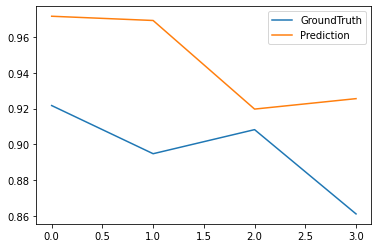

In [181]:
import mplfinance as mpf
import matplotlib.pyplot as plt
idx = 10
plt.figure()
plt.plot(trues[idx,:,0], label='GroundTruth')
plt.plot(preds[idx,:,0], label='Prediction')
plt.legend()
plt.show()